# Importing packages

In [2]:
# Importing the packages
import pandas as pd
import numpy as np
from google.colab import drive
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.feature_selection import mutual_info_classif


from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, LabelEncoder


# Loading & prepping the data

In [ ]:
from google.colab import drive
import pandas as pd
# Load in the data
drive.mount('/content/drive')

Mounted at /content/drive


In [76]:
# Define file paths
ratings_file = '/content/drive/My Drive/Thesis/Data/ml-1m/ratings.dat'
users_file = '/content/drive/My Drive/Thesis/Data/ml-1m/users.dat'
movies_file = '/content/drive/My Drive/Thesis/Data/ml-1m/movies.dat'

# Load datasets
ratings = pd.read_csv(ratings_file, sep='::', header=None, names=['UserID', 'MovieID', 'Rating', 'Timestamp'], engine='python')
users = pd.read_csv(users_file, sep='::', header=None, names=['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code'], engine='python')
movies = pd.read_csv(movies_file, sep='::', header=None, names=['MovieID', 'Title', 'Genres'], engine='python', encoding='ISO-8859-1')

In [77]:
# Prepare ratings file for EDA
ratings['Timestamp'] = ratings['Timestamp'].apply(datetime.fromtimestamp)
ratings['Year'] = ratings['Timestamp'].dt.year
ratings['Month'] = ratings['Timestamp'].dt.month
ratings['Day'] = ratings['Timestamp'].dt.day
ratings['Hour'] = ratings['Timestamp'].dt.hour

# Removing the timestamp
ratings = ratings.drop(columns=["Timestamp"])

In [79]:
# Prepare users file for EDA
# Change gender labels
gender_mapping = {
    'F': "Female", 'M': "Male"
}
users['Gender'] = users['Gender'].map(gender_mapping)

# Change occupation labels
occupation_mapping = {
    0: "Other or not specified", 1: "Academic/educator", 2: "Artist",
    3: "Clerical/admin", 4: "College/grad student", 5: "Customer service",
    6: "Doctor/health care", 7: "Executive/managerial", 8: "Farmer",
    9: "Homemaker", 10: "K-12 student", 11: "Lawyer", 12: "Programmer",
    13: "Retired", 14: "Sales/marketing", 15: "Scientist", 16: "Self-employed",
    17: "Technician/engineer", 18: "Tradesman/craftsman", 19: "Unemployed",
    20: "Writer"
}
users['Occupation'] = users['Occupation'].map(occupation_mapping)

# Change Age labels
age_mapping = {
    1: "Under 18", 18: "18-24", 25: "25-34", 35: "35-44",
    45: "45-49", 50: "50-55", 56: "56+"
}
users['Age'] = users['Age'].map(age_mapping)

# Remove Zip-code
users = users.drop(columns=["Zip-code"])

In [ ]:
# #OLD CODE!!!
# # Separate release year from title
# movies['Release_year'] = movies.Title.str.extract("\((\d{4})\)", expand=True).astype(str)
# movies['Release_year'] = pd.to_datetime(movies.Release_year, format='%Y')
# movies['Release_year'] = movies.Release_year.dt.year
# movies['Title'] = movies.Title.str[:-7]

In [81]:
# Prepare movies file for EDA

# Seperate release year from title
movies['Release_year'] = movies.Title.str.extract("\((\d{4})\)", expand=True).astype(str)
movies['Title'] = movies.Title.str[:-7]

# Separating the genres
# Unique genres
genres_unique = pd.DataFrame(movies.Genres.str.split('|').tolist()).stack().unique()
genres_unique = pd.DataFrame(genres_unique, columns=['Genre'])
# Remove old Genres column in dummy df
movies_dummy = movies.join(movies.Genres.str.get_dummies().astype(bool))
movies_dummy.drop('Genres', inplace=True, axis=1)

**df** is the dataframe with genres still as string,
**df_movies** is dataframe where genres are separated and transformed into dummies

In [82]:
# Merge the seperate datasets
ratings_plus_users = pd.merge(ratings, users, on='UserID')
df = pd.merge(ratings_plus_users, movies, on='MovieID')
df_movies = pd.merge(ratings_plus_users, movies_dummy, on='MovieID')

In [3]:
# Checkpoint
#df.to_csv('/content/drive/My Drive/Thesis/Data/eda_df.csv', index=False)
#df_movies.to_csv('/content/drive/My Drive/Thesis/Data/eda_df_movies.csv', index=False)
df = pd.read_csv('/content/drive/My Drive/Thesis/Data/eda_df.csv')
df_movies = pd.read_csv('/content/drive/My Drive/Thesis/Data/eda_df_movies.csv')

# EDA

### Distribution of ratings

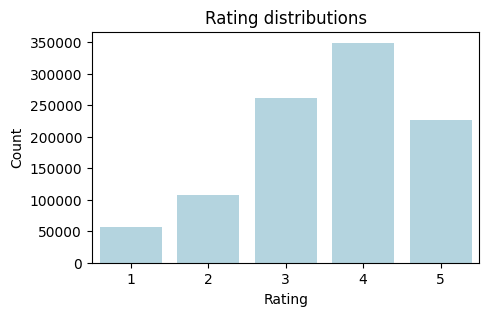

In [87]:
# Plot the distribution of ratings
plt.figure(figsize=(5, 3))
sns.countplot(x=df['Rating'], color='lightblue')
plt.title('Rating distributions')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

### Distribution of age, gender, occupation and genre (Genres not separated)

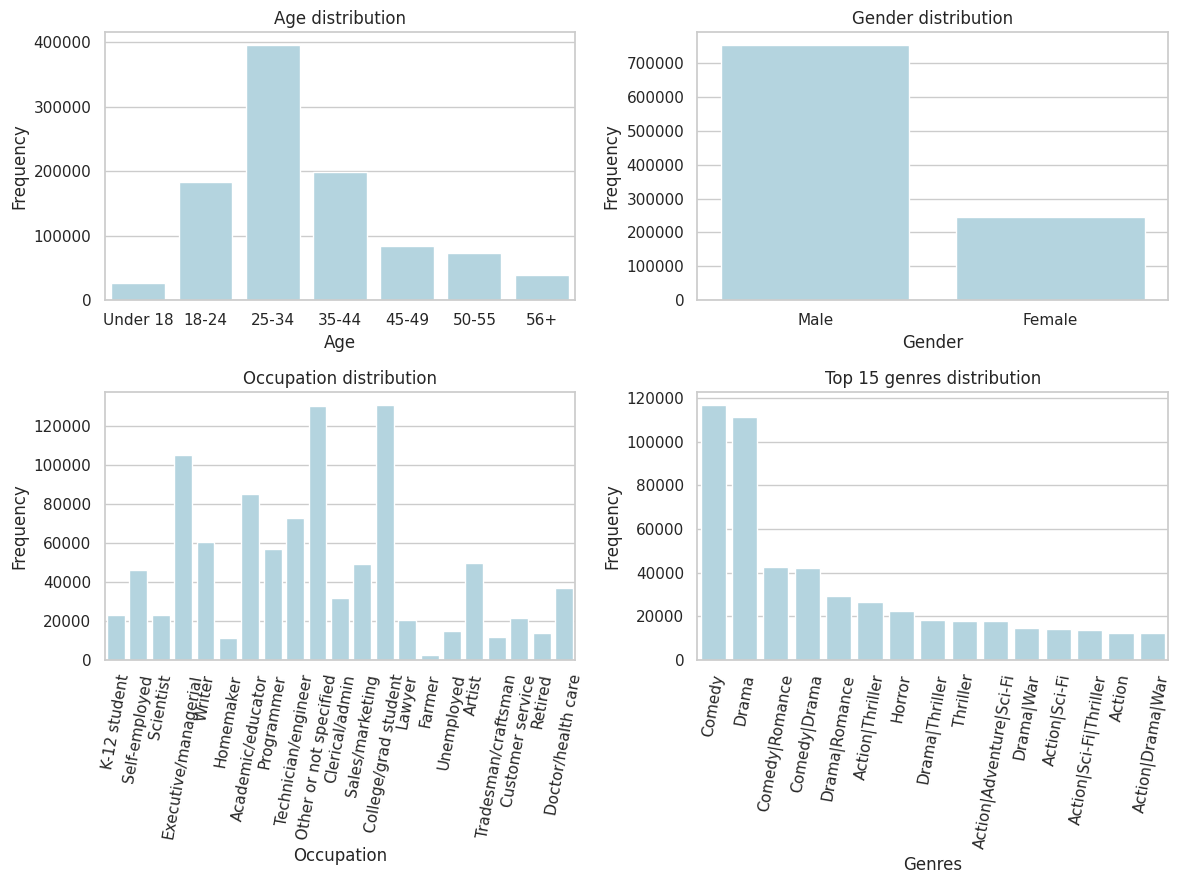

In [136]:
# Distribution of categorical features
# Create the 2x2 grid for the plots
fig, axes = plt.subplots(2, 2, figsize=(12, 9))

# Plot Age
age_order = list(age_mapping.values())
sns.countplot(ax=axes[0, 0], x=df['Age'], order=age_order, color='lightblue')
axes[0, 0].set_title('Age distribution')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_xlabel('Age')

# Plot Gender
sns.countplot(ax=axes[0, 1], x=df['Gender'],
              order=df['Gender'].value_counts().index,
              color='lightblue')
axes[0, 1].set_title('Gender distribution')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_xlabel('Gender')

# Plot Occupation
sns.countplot(ax=axes[1, 0], x=df['Occupation'], color='lightblue')
axes[1, 0].set_title('Occupation distribution')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_xlabel('Occupation')
for item in axes[1, 0].get_xticklabels():
    item.set_rotation(80)

# Plot Genres (Top 15 most frequent genres)
top_genres = df['Genres'].value_counts().nlargest(15).index
sns.countplot(ax=axes[1, 1], x=df[df['Genres'].isin(top_genres)]['Genres'],
              order=top_genres, color='lightblue')
axes[1, 1].set_title('Top 15 genres distribution')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_xlabel('Genres')
for item in axes[1, 1].get_xticklabels():
    item.set_rotation(80)

# Adjust layout
plt.tight_layout()
plt.show()

### Distribution of genre (genres separated)

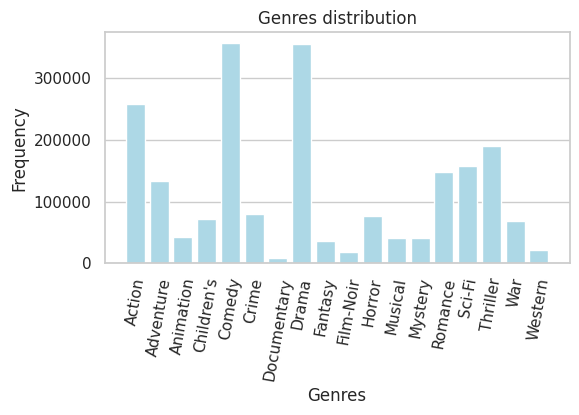

In [134]:
# List of genres
genres = ['Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime', 'Documentary',
          'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance',
          'Sci-Fi', 'Thriller', 'War', 'Western']

# Frequency of Genres
ratings_count = {}
for genre in genres:
    ratings_count[genre] = df_movies[df_movies[genre] == 1]['Rating'].count()

# Plotting the frequency of ratings per genre
plt.figure(figsize=(6, 3))
plt.bar(ratings_count.keys(), ratings_count.values(), color='lightblue')
plt.xlabel('Genres')
plt.ylabel('Frequency')
plt.title('Genres distribution')
plt.xticks(rotation=80)
plt.grid(axis = 'x')
plt.show()

### Distribution of ratings with histogram & kernel density plot



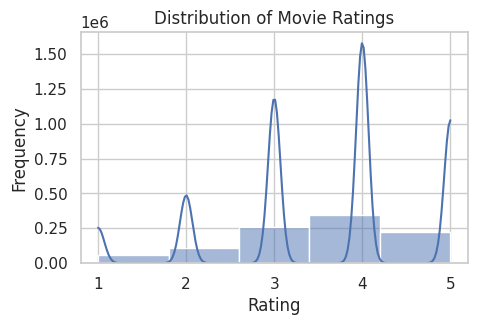

In [95]:
# Visualize the distribution of ratings using histograms and kernel density plots
# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Create the histogram with KDE plot
plt.figure(figsize=(5, 3))
sns.histplot(df['Rating'], bins=5, kde=True)
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

### Top 10 movies by average ratings and number of ratings

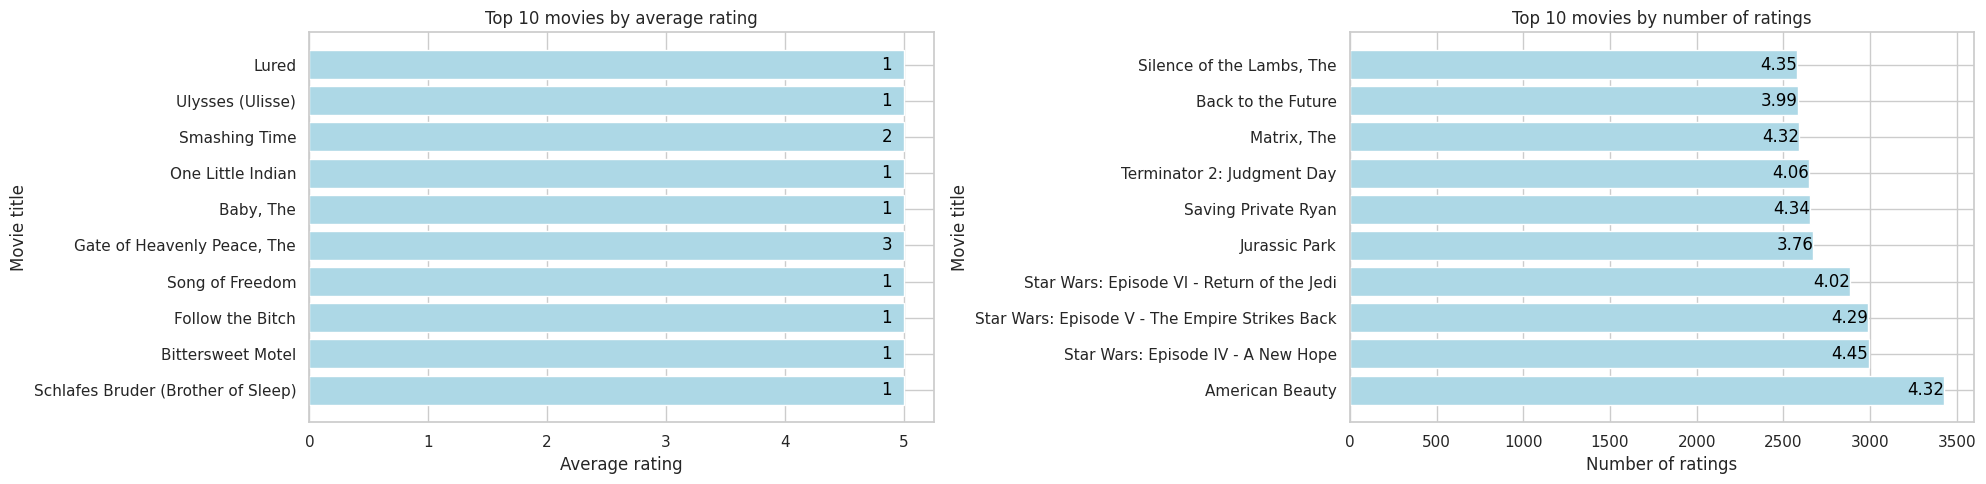

In [127]:
# Calculate the average rating for each movie
average_ratings = df_movies.groupby(['MovieID', 'Title'])['Rating'].mean().reset_index()
average_ratings.columns = ['MovieID', 'Title', 'AverageRating']

# Calculate the number of ratings for each movie
rating_counts = df_movies.groupby(['MovieID', 'Title'])['Rating'].count().reset_index()
rating_counts.columns = ['MovieID', 'Title', 'RatingCount']

# Merge the average ratings and rating counts into a single DataFrame
movie_stats = pd.merge(average_ratings, rating_counts, on=['MovieID', 'Title'])

# Sort the movies by average rating and by the number of ratings
top_movies_by_avg_rating = movie_stats.sort_values(by='AverageRating', ascending=False).head(10)
top_movies_by_rating_count = movie_stats.sort_values(by='RatingCount', ascending=False).head(10)

# Create a 1x2 grid for the plots
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Plot the top 10 movies by average rating
bars1 = axs[0].barh(top_movies_by_avg_rating['Title'], top_movies_by_avg_rating['AverageRating'], color='lightblue')
axs[0].set_xlabel('Average rating')
axs[0].set_ylabel('Movie title')
axs[0].set_title('Top 10 movies by average rating')

# Add number of ratings inside the bars
for bar, rating_count in zip(bars1, top_movies_by_avg_rating['RatingCount']):
    axs[0].text(bar.get_width() - 0.1, bar.get_y() + bar.get_height()/2, f'{rating_count}', va='center', ha='right', color='black')

# Plot the top 10 movies by number of ratings
bars2 = axs[1].barh(top_movies_by_rating_count['Title'], top_movies_by_rating_count['RatingCount'], color='lightblue')
axs[1].set_xlabel('Number of ratings')
axs[1].set_ylabel('Movie title')
axs[1].set_title('Top 10 movies by number of ratings')

# Add average rating inside the bars
for bar, avg_rating in zip(bars2, top_movies_by_rating_count['AverageRating']):
    axs[1].text(bar.get_width() - 0.1, bar.get_y() + bar.get_height()/2, f'{avg_rating:.2f}', va='center', ha='right', color='black')

# Adjust layout
plt.tight_layout()
plt.show()

### Average rating per Occupation, Gender, Age and Genre

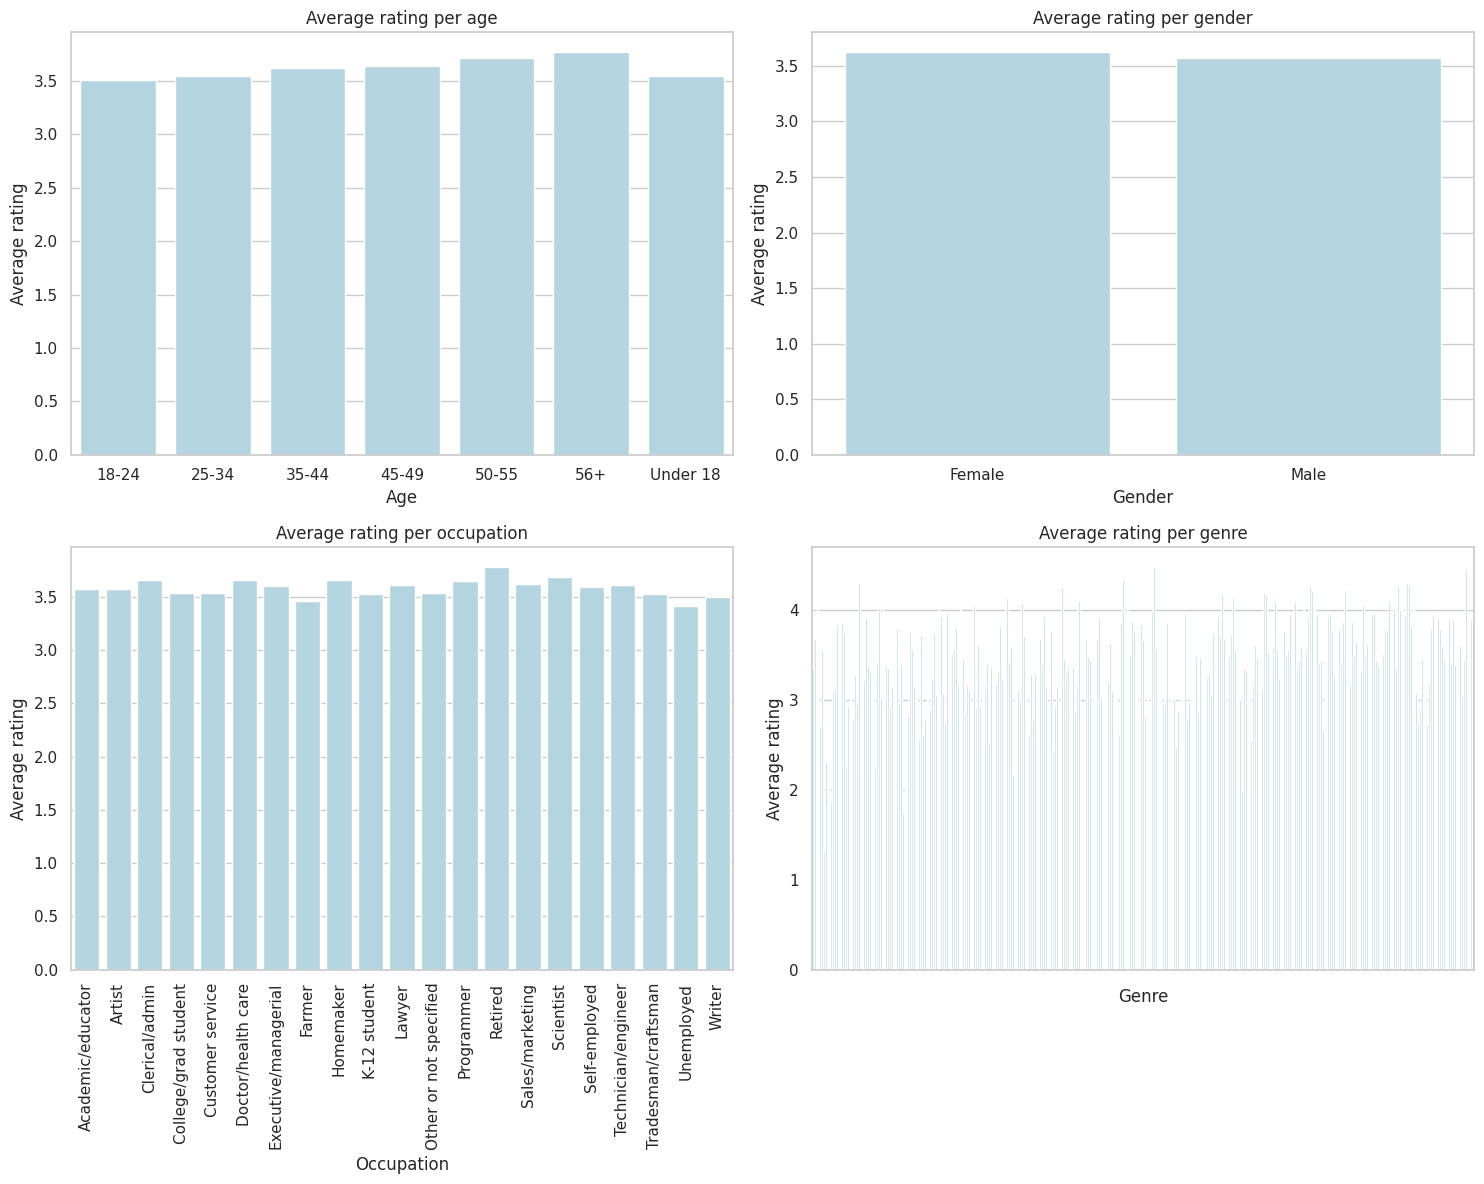

In [132]:
# Calculate the average rating per Occupation, Gender, Age, and Genre
avg_rating_occupation = df.groupby('Occupation')['Rating'].mean()
avg_rating_gender = df.groupby('Gender')['Rating'].mean()
avg_rating_age = df.groupby('Age')['Rating'].mean()
avg_rating_genre = df.groupby('Genres')['Rating'].mean()

# Create the 2x2 grid for the plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot average rating per Age
sns.barplot(ax=axes[0, 0], x=avg_rating_age.index, y=avg_rating_age.values, color='lightblue')
axes[0, 0].set_title('Average rating per age')
axes[0, 0].set_ylabel('Average rating')
axes[0, 0].set_xlabel('Age')

# Plot average rating per Gender
sns.barplot(ax=axes[0, 1], x=avg_rating_gender.index, y=avg_rating_gender.values, color='lightblue')
axes[0, 1].set_title('Average rating per gender')
axes[0, 1].set_ylabel('Average rating')
axes[0, 1].set_xlabel('Gender')

# Plot average rating per Occupation
sns.barplot(ax=axes[1, 0], x=avg_rating_occupation.index, y=avg_rating_occupation.values, color='lightblue')
axes[1, 0].set_title('Average rating per occupation')
axes[1, 0].set_ylabel('Average rating')
axes[1, 0].set_xlabel('Occupation')
for item in axes[1, 0].get_xticklabels():
    item.set_rotation(90)

# Plot average rating per Genre
sns.barplot(ax=axes[1, 1], x=avg_rating_genre.index, y=avg_rating_genre.values, color='lightblue')
axes[1, 1].set_title('Average rating per genre')
axes[1, 1].set_ylabel('Average rating')
axes[1, 1].set_xlabel('Genre')
axes[1, 1].set_xticklabels([])

# Adjust layout
plt.tight_layout()
plt.show()

### Average rating per genre

Investigate how different genres are rated by calculating average ratings for each genre. Group the dataset by genre and compute the average rating for each genre. Use bar charts to display these averages, and also include the count of movies within each genre. This analysis will help you identify which genres receive higher ratings and how many films are represented in each genre, providing insight into user preferences.

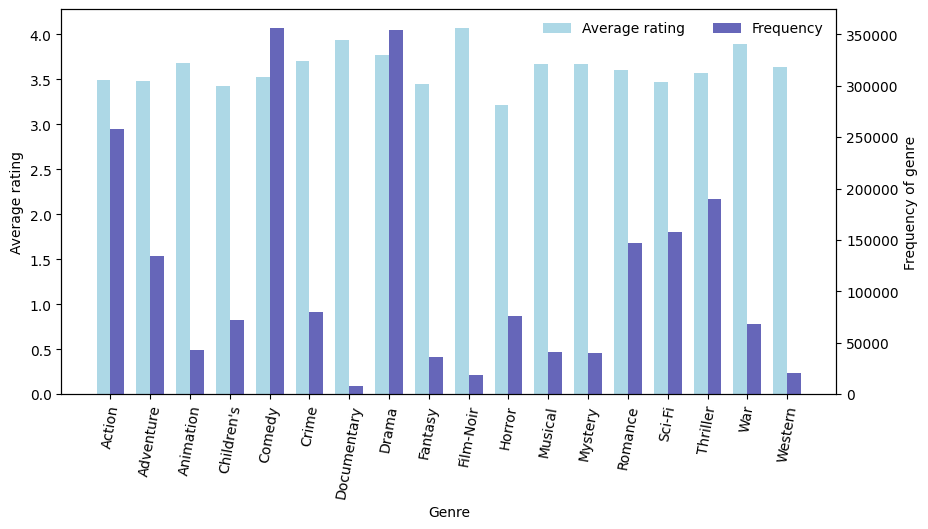

In [27]:
# Calculate average rating per genre
df_exploded = df.assign(Genres=df['Genres'].str.split('|')).explode('Genres')
avg_ratings = df_exploded.groupby('Genres')['Rating'].mean().reset_index()

# Calculate frequency per genre
rating_counts = df_exploded.groupby('Genres')['Rating'].count().reset_index()
rating_counts.columns = ['Genres', 'Count']

# Dataframe for the plot
genre_stats = pd.merge(avg_ratings, rating_counts, on='Genres')

# Preparing for the plot
x = np.arange(len(genre_stats['Genres']))
width = 0.35
fig, ax1 = plt.subplots(figsize=(10, 5))

# Average rating axis
bars1 = ax1.bar(x - width/2, genre_stats['Rating'], width, color='lightblue',
                label='Average rating')
ax1.set_xlabel('Genre')
ax1.set_ylabel('Average rating')

# Frequency axis
ax2 = ax1.twinx()
bars2 = ax2.bar(x + width/2, genre_stats['Count'], width, color='darkblue',
                alpha=0.6, label='Frequency')
ax2.set_ylabel('Frequency of genre')

# Label the axis
ax1.set_xticks(x)
ax1.set_xticklabels(genre_stats['Genres'], rotation=80)

# Create legend
bars = [bars1[0], bars2[0]]
labels = ['Average rating', 'Frequency']
ax1.legend(bars, labels, loc='upper right', ncols = 2, frameon=False)

plt.show()


Film-Noir has highest average rating, but also the least ratings in total. Comedy and Drama are most rated, more representative for whole group.

### Number of movies per genre

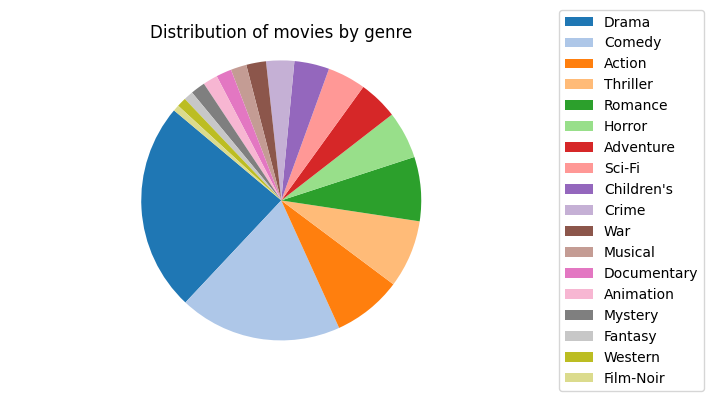

In [56]:
# Dataframe with each MovieID only once
df_unique_movies = df.drop_duplicates(subset=['MovieID'])

# Split genres and explode the DataFrame
df_exploded = df_unique_movies.assign(Genres=df_unique_movies['Genres'].str.split('|')).explode('Genres')

# Frequency per genre
genre_counts = df_exploded['Genres'].value_counts()

# Plot the pie chart
plt.figure(figsize=(7, 4))
pie_wedges, texts = plt.pie(genre_counts, startangle=140, colors=plt.cm.tab20.colors)

# Add a legend to the right side of the plot
plt.legend(pie_wedges, genre_counts.index, loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Distribution of movies by genre')
plt.axis('equal')

plt.show()


This means we can most likely get better predictions for the drama genres than for film-noir

### Top 40 highest rated movies

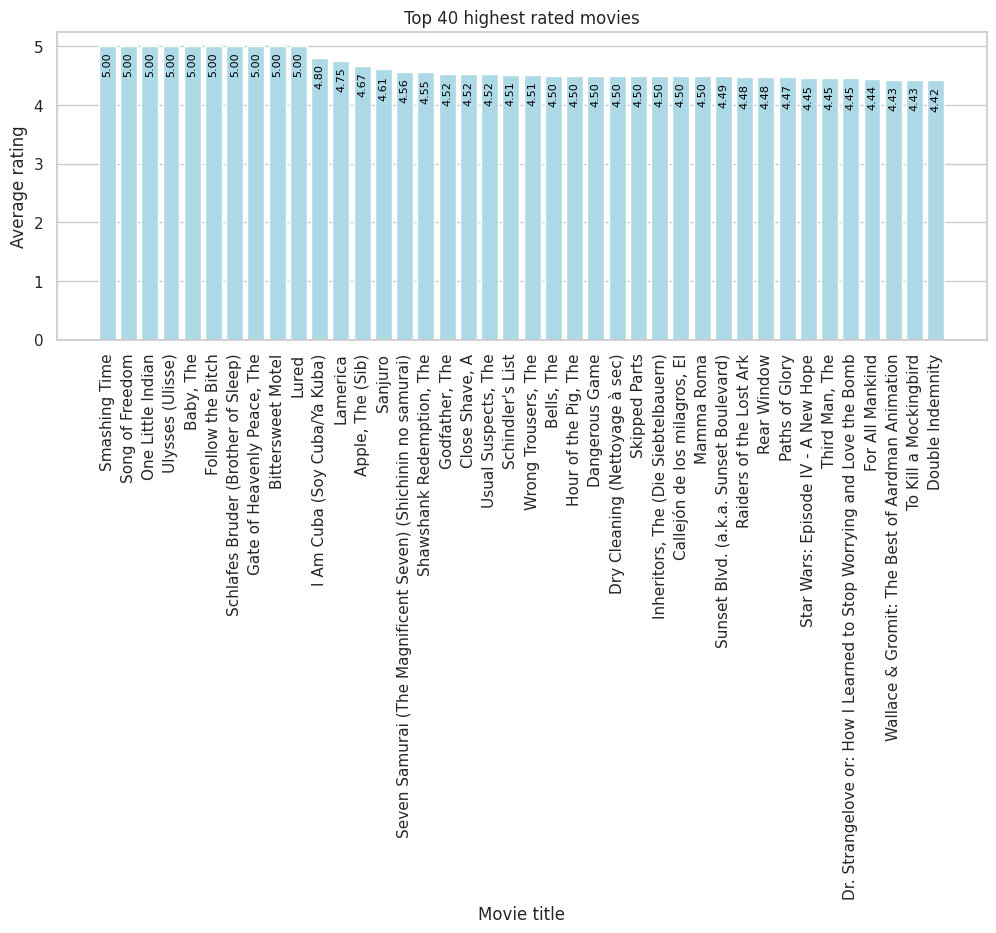

In [144]:
# Calculate the average rating for each movie
average_ratings = df.groupby('Title')['Rating'].mean().sort_values(ascending=False).head(40).reset_index()

# Plot the top 40 highest rated movies
plt.figure(figsize=(12, 4))
bars = plt.bar(average_ratings['Title'], average_ratings['Rating'], color='lightblue')
plt.title('Top 40 highest rated movies')
plt.xlabel('Movie title')
plt.ylabel('Average rating')
plt.xticks(rotation=90)
plt.grid(axis = 'x')

# Add the average rating inside the bars, rotated by 90 degrees
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height - 0.1, f'{height:.2f}',
             ha='center', va='top', rotation=90, color='black', fontsize=8)

plt.show()


### User behavior

In [57]:
df.columns

Index(['UserID', 'MovieID', 'Rating', 'Year', 'Month', 'Day', 'Hour', 'Gender',
       'Age', 'Occupation', 'Title', 'Genres', 'Release_year'],
      dtype='object')

### Correlation heatmap of categorical features

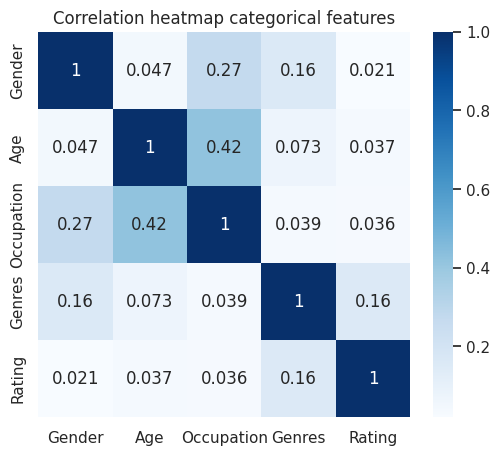

In [150]:
# Function for calculating Cramér's V
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# List of categorical columns
categorical_columns = ['Gender', 'Age', 'Occupation', 'Genres', 'Rating']

# Create a correlation matrix
corr_matrix = pd.DataFrame(index=categorical_columns, columns=categorical_columns)

for col1 in categorical_columns:
    for col2 in categorical_columns:
        corr_matrix.loc[col1, col2] = cramers_v(df[col1], df[col2])

# Convert to float
corr_matrix = corr_matrix.astype(float)

# Plot the heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, cmap='Blues')
plt.title('Correlation heatmap categorical features')
plt.show()

### Correlation heatmap of genres

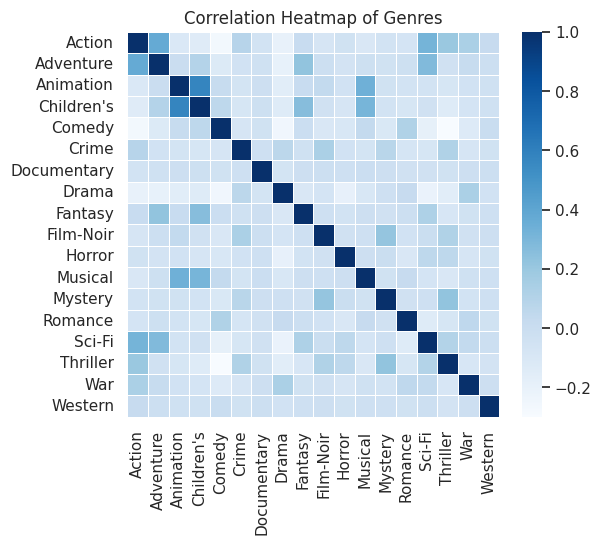

In [145]:
# Extract the genre columns
df_genres = df_movies[genres]

# Calculate the correlation matrix
corr_matrix = df_genres.corr()

# Plot the heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=False, cmap='Blues', linewidths=0.5)
plt.title('Correlation heatmap of genres')
plt.show()

### Information gain per features

In [151]:
df.columns

Index(['UserID', 'MovieID', 'Rating', 'Year', 'Month', 'Day', 'Hour', 'Gender',
       'Age', 'Occupation', 'Title', 'Genres', 'Release_year'],
      dtype='object')

In [152]:
# List of features to calculate information gain
features = ['UserID', 'MovieID', 'Year', 'Month', 'Day', 'Hour', 'Gender',
            'Age', 'Occupation', 'Title', 'Genres', 'Release_year']

# Encode only categorical variables to numerical codes
df_encoded = df[features].apply(lambda x: x.astype('category').cat.codes if x.dtype == 'object' else x)

# Calculate the information gain (mutual information) for each feature with respect to the target variable 'Rating'
info_gain = mutual_info_classif(df_encoded, df['Rating'], discrete_features=True)

# Create a DataFrame to display the results
info_gain_df = pd.DataFrame({'Feature': features, 'Information Gain': info_gain})

# Sort the DataFrame by Information Gain in descending order
info_gain_df = info_gain_df.sort_values(by='Information Gain', ascending=False)

print(info_gain_df)


         Feature  Information Gain
1        MovieID          0.148844
9          Title          0.148112
0         UserID          0.133094
10        Genres          0.046730
11  Release_year          0.017636
7            Age          0.002731
8     Occupation          0.002650
4            Day          0.000996
2           Year          0.000718
3          Month          0.000659
5           Hour          0.000611
6         Gender          0.000229


### Information gain per genre

In [153]:
# Convert categorical variables to numerical codes
df_encoded_2 = df_movies[genres].apply(lambda x: x.astype('category').cat.codes)

# Calculate the information gain (mutual information) for each categorical variable with respect to the target variable 'Rating'
info_gain = mutual_info_classif(df_encoded_2, df_movies['Rating'], discrete_features=True)

# Create a DataFrame to display the results
info_gain_df = pd.DataFrame({'Feature': genres, 'Information Gain': info_gain})

# Sort the DataFrame by Information Gain in descending order
info_gain_df = info_gain_df.sort_values(by='Information Gain', ascending=False)

print(info_gain_df)

        Feature  Information Gain
7         Drama          0.007718
10       Horror          0.004388
16          War          0.003304
9     Film-Noir          0.002009
0        Action          0.001162
14       Sci-Fi          0.001065
4        Comedy          0.000873
3    Children's          0.000822
1     Adventure          0.000739
5         Crime          0.000583
6   Documentary          0.000451
13      Romance          0.000429
8       Fantasy          0.000302
2     Animation          0.000239
11      Musical          0.000141
12      Mystery          0.000138
15     Thriller          0.000082
17      Western          0.000033


### User-Movie doubles check

In [ ]:
# Check that no user has rated the same movie twice
# Group by MovieID and UserID and count occurrences
duplicate_counts = df.groupby(['MovieID', 'UserID']).size().reset_index(name='count')

# Filter to find combinations with more than one occurrence
duplicates = duplicate_counts[duplicate_counts['count'] > 1]

print(duplicates)

Empty DataFrame
Columns: [MovieID, UserID, count]
Index: []


Empty dataframe meaning: No double combinations in usersID and movieID -> no user has rated the same movie twice